* Data Selection: master.CCV - https://www.transit.dot.gov/ntd/data-product/monthly-module-raw-data-release
* Data Preprocessing: data cleaning and data formating for utilization for making new variables
    * Added numeric values to new data frame to make correlation matrix of numeric values.


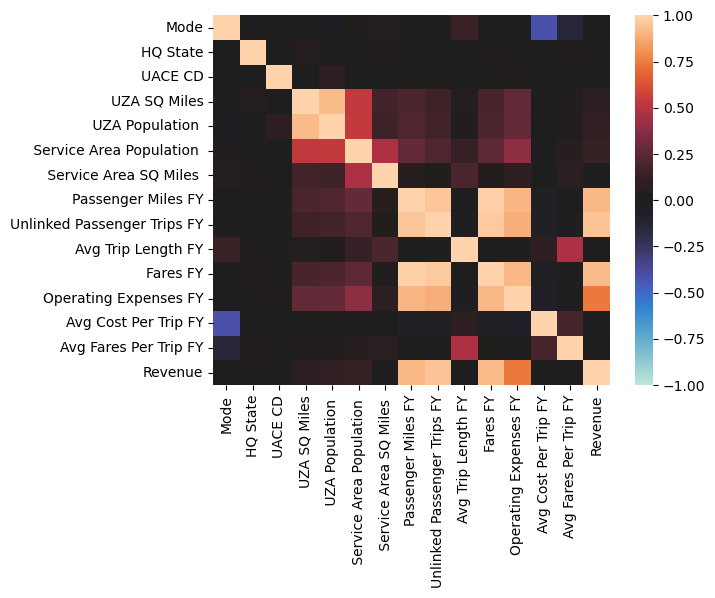

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

"""
file reading resulted in an error. encoding iso fixed the issue reading unkown character
"""
df = pd.read_csv("master.csv", encoding = "ISO-8859-1")

df[' UZA Population '] = df[' UZA Population '].str.replace(r'[^0-9]', '', regex=True).astype(float)
df[' UZA Population '] = pd.to_numeric(df[' UZA Population '], errors='coerce')

df[' Service Area Population '] = df[' Service Area Population '].str.replace('-', '0')
df[' Service Area Population '] = df[' Service Area Population '].str.replace(r'[^0-9]', '', regex=True).astype(float)
df[' Service Area Population '] = pd.to_numeric(df[' Service Area Population '], errors='coerce')

df[' Service Area SQ Miles '] = df[' Service Area SQ Miles '].str.replace('-', '0')
df[' Service Area SQ Miles '] = df[' Service Area SQ Miles '].str.replace(r'[^0-9]', '', regex=True).astype(float)
df[' Service Area SQ Miles '] = pd.to_numeric(df[' Service Area SQ Miles '], errors='coerce')

df['Operating Expenses FY'] = df['Operating Expenses FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Operating Expenses FY'] = pd.to_numeric(df['Operating Expenses FY'], errors='coerce')
df['Operating Expenses FY'] = df['Operating Expenses FY'] / 100

df['Fares FY'] = df['Fares FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Fares FY'] = pd.to_numeric(df['Fares FY'], errors='coerce')
df['Fares FY'] = df['Fares FY'] / 100

df['Avg Fares Per Trip FY'] = df['Avg Fares Per Trip FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Avg Fares Per Trip FY'] = pd.to_numeric(df['Avg Fares Per Trip FY'], errors='coerce')
df['Avg Fares Per Trip FY'] = df['Avg Fares Per Trip FY'] / 100

df['Unlinked Passenger Trips FY'] = df['Unlinked Passenger Trips FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Unlinked Passenger Trips FY'] = pd.to_numeric(df['Unlinked Passenger Trips FY'], errors='coerce')

df['Avg Cost Per Trip FY'] = df['Avg Cost Per Trip FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Avg Cost Per Trip FY'] = pd.to_numeric(df['Avg Cost Per Trip FY'], errors='coerce')
df['Avg Cost Per Trip FY'] = df['Avg Cost Per Trip FY'] / 100

df['Passenger Miles FY'] = df['Passenger Miles FY'].str.replace(r'[^0-9]', '', regex=True)
df['Passenger Miles FY'] = pd.to_numeric(df['Passenger Miles FY'], errors='coerce')
df = df[df['Passenger Miles FY'] != 0]
df = df[~(df['Status'].isna() | (df['Status'] == 'Inactive'))]
df['Revenue'] = (df['Avg Cost Per Trip FY'] * df['Unlinked Passenger Trips FY'] * df['Passenger Miles FY'] * df['Fares FY']) - df['Operating Expenses FY']

#print(df['Status'])
#print(df['Revenue'])

df['Mode'] = df['Mode'].astype('category').cat.codes
df['HQ State'] = df['HQ State'].astype('category').cat.codes

df_1 = df[['Mode', 'HQ State', 'UACE CD', 'UZA SQ Miles', ' UZA Population ', ' Service Area Population ', ' Service Area SQ Miles ', 'Passenger Miles FY',
          'Unlinked Passenger Trips FY', 'Avg Trip Length FY', 'Fares FY', 'Operating Expenses FY', 'Avg Cost Per Trip FY', 
            'Avg Fares Per Trip FY', 'Revenue']]
corr_matrix = df_1.corr()
corr_matrix.round(2)

sns.heatmap(corr_matrix, vmin = -1, vmax = 1, center = 0)
plt.show()

#to do
#visualize each feature to better decide on a model (box and whisker diagrams)
#map different states to regions or numbers
#two models (tree, oner or naive bayes)
#cross-validation
#accuracy (ROC curve, precision/recall curve)

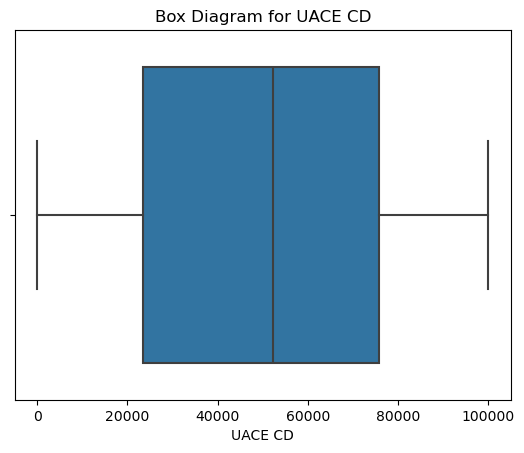

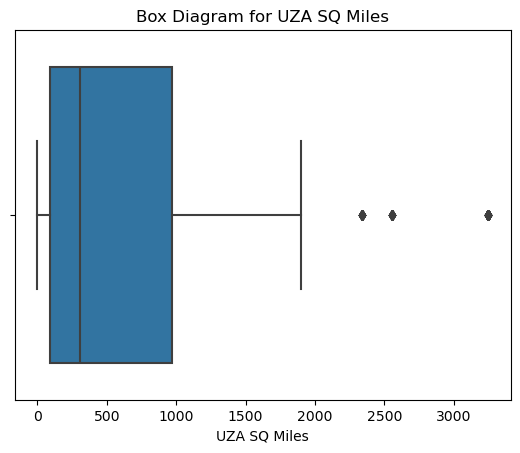

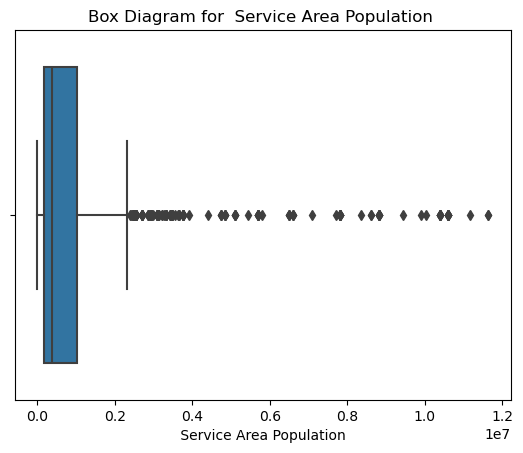

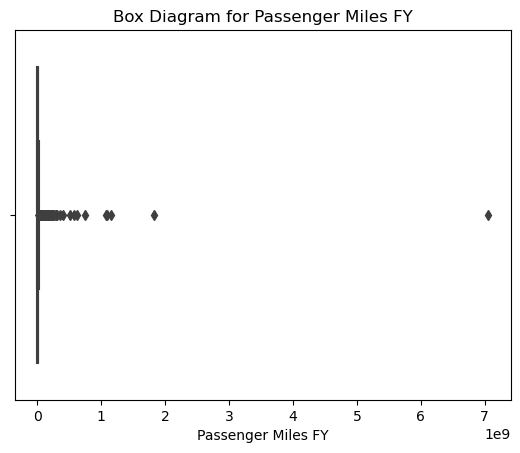

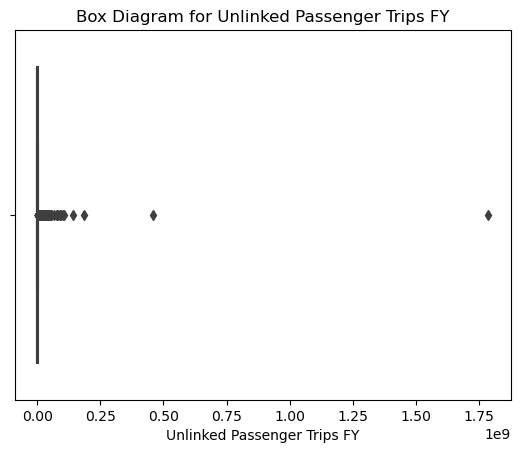

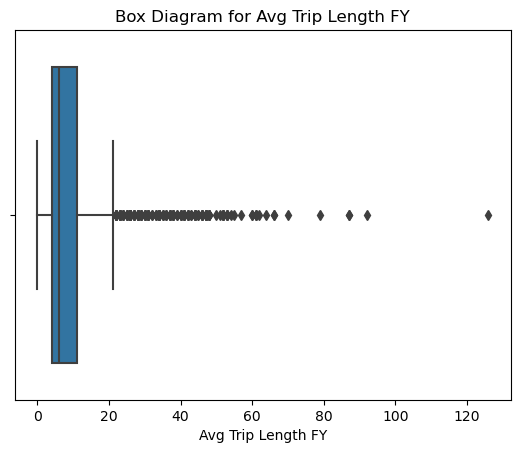

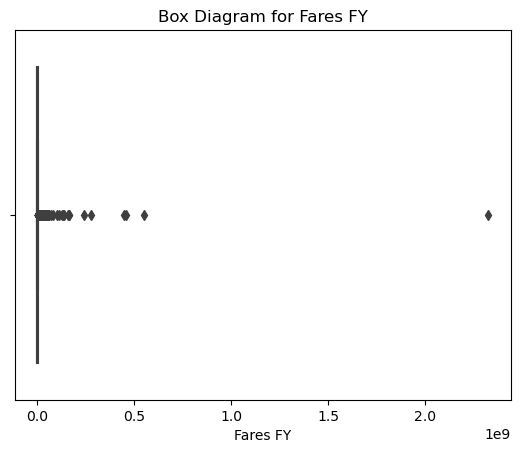

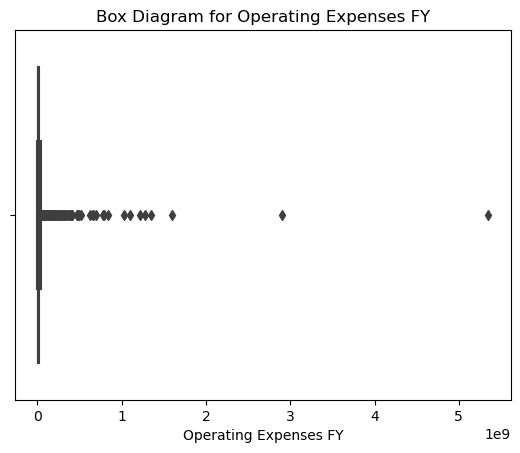

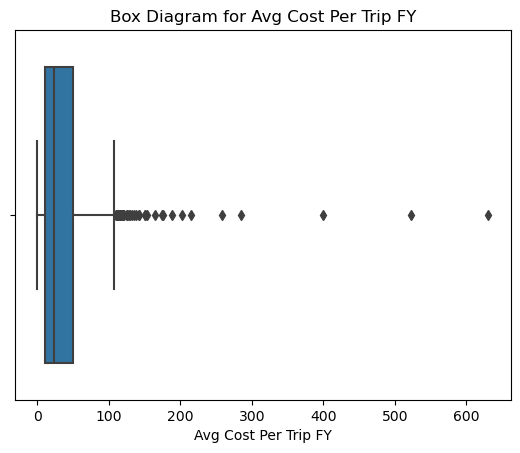

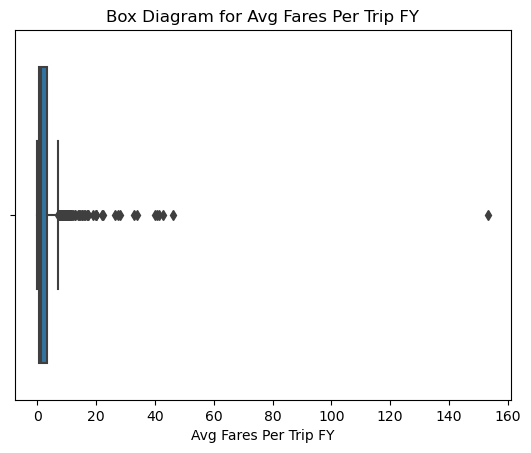

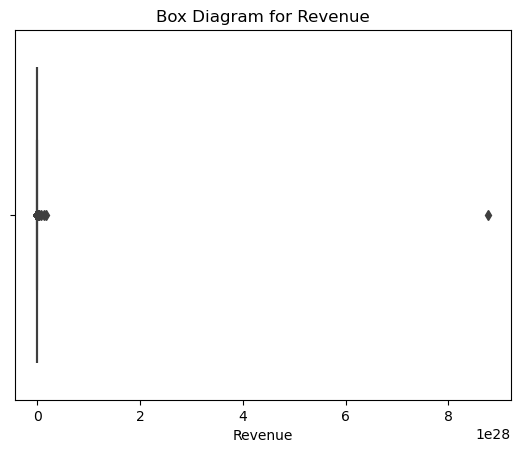

In [2]:
#visualize each feature to better decide on a model (box and whisker diagrams)
features = df[['UACE CD', 'UZA SQ Miles',' Service Area Population ', 'Passenger Miles FY',
          'Unlinked Passenger Trips FY', 'Avg Trip Length FY', 'Fares FY', 'Operating Expenses FY', 'Avg Cost Per Trip FY', 
            'Avg Fares Per Trip FY', 'Revenue']]

for feature in features:
    plt.figure()
    sns.boxplot(x=feature, data=df)
    plt.title(f'Box Diagram for {feature}')
    plt.show()

In [3]:
#scatterplot ======== (revenue, operating expense, unliked trips, pasnager miles, uzasqmiles, usz population, service area popualtion, fares)

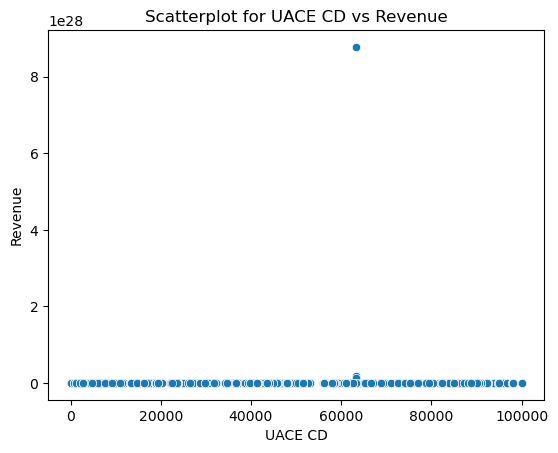

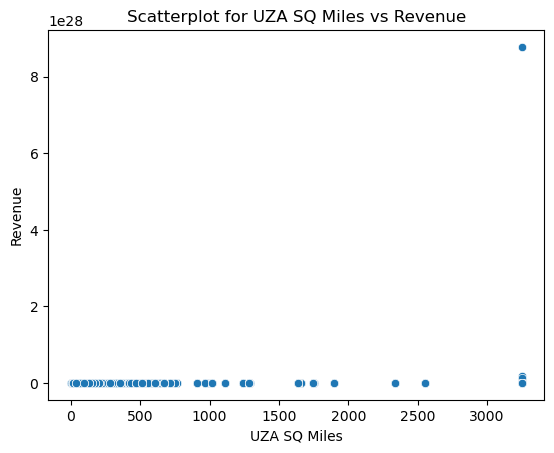

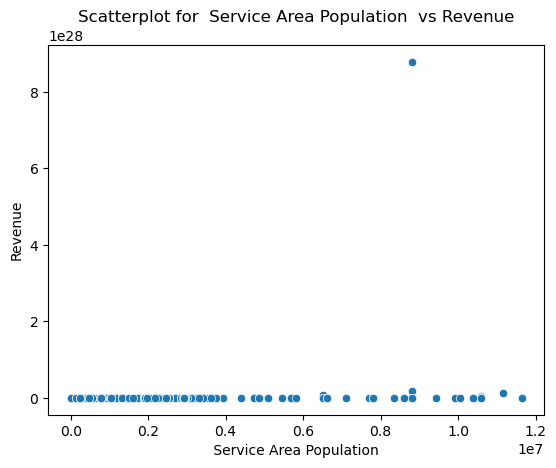

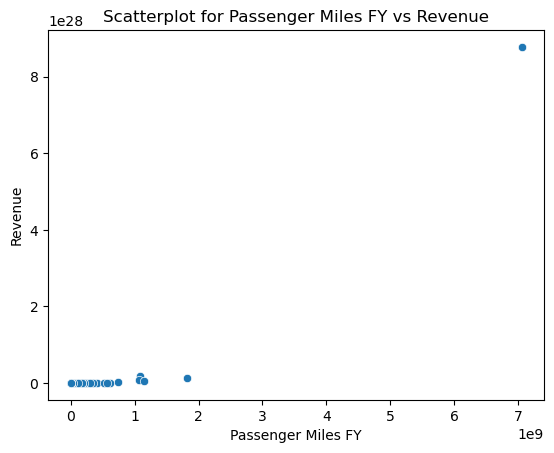

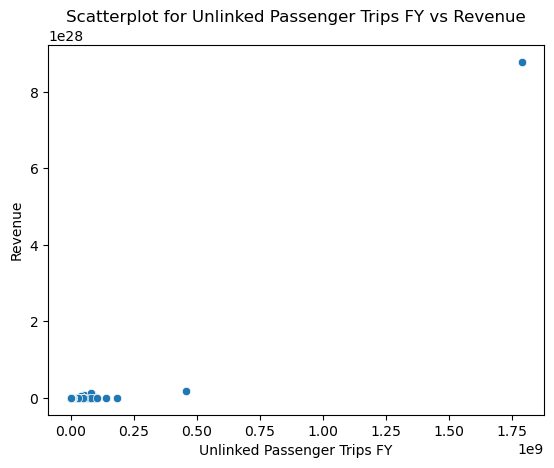

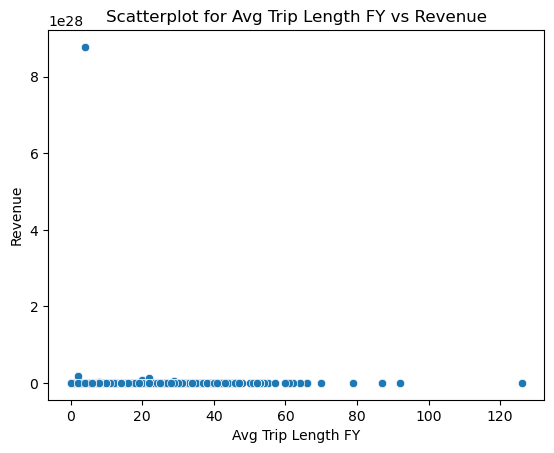

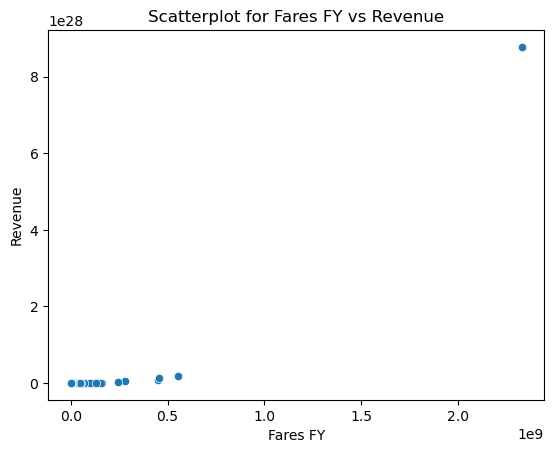

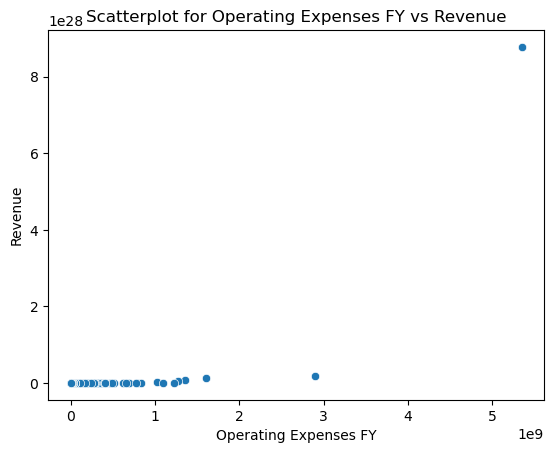

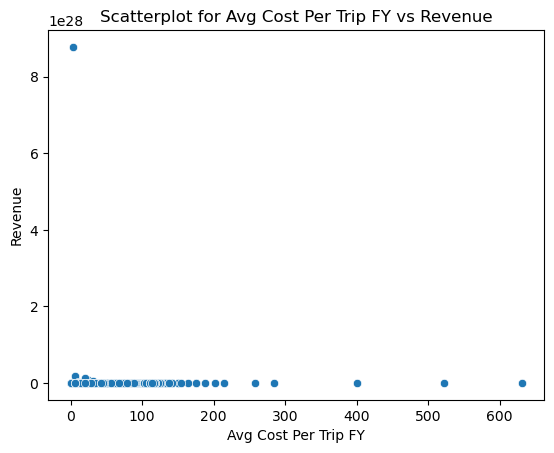

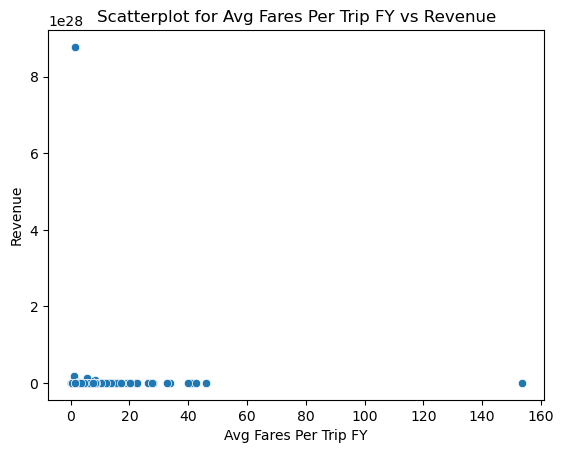

In [4]:
# making the scatterPlot for the making of the features
for feature in features:
    if feature != 'Revenue':
        plt.figure()
        sns.scatterplot(x=feature, y='Revenue', data=df)
        plt.title(f'Scatterplot for {feature} vs Revenue')
        plt.show()